# Merge Datasets and Analysis

# General

## Imports

In [1]:
import os
import pandas as pd
import seaborn as sns


## Constants

In [2]:
PATH_PROTECED_AREA = 'data/OECD/protected_areas_2020.csv'
PATH_LAND_COVER = 'data/OECD/LAND_COVER_2018_DATA.csv'
PATH_AIR = 'data/OECD/greenhouse_gases_2020_pred.csv'
PATH_CLIMATE = 'data/climate/climate_features.csv'
PATH_IUCN = 'data/IUCN/scraped'
PATHS_COUN = [PATH_PROTECED_AREA, PATH_LAND_COVER, PATH_CLIMATE, PATH_AIR] # AIR IS MISSING

# IUCN Data

## Load and Concatenate

In [3]:
iucn_list = []
for _, _, files in os.walk(PATH_IUCN):
    for file in files:
        temp = pd.read_csv(PATH_IUCN + '/' + file)
        temp['Country'] = file.split('.csv')[0]
        iucn_list.append(temp)
iucn_data = pd.concat(iucn_list)

## Analysis

### General Information

In [4]:
iucn_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92479 entries, 0 to 1128
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kingdom_class    92479 non-null  object
 1   common_name      62049 non-null  object
 2   scientific_name  92479 non-null  object
 3   trend            90433 non-null  object
 4   region           92479 non-null  object
 5   threat_level     92479 non-null  object
 6   Country          92479 non-null  object
dtypes: object(7)
memory usage: 5.6+ MB


### Check Uniue Values

In [5]:
for c in iucn_data.columns:
    print('Column >>{}<< contains {} unique values.'.format(c, iucn_data[c].nunique()))

Column >>kingdom_class<< contains 29 unique values.
Column >>common_name<< contains 23062 unique values.
Column >>scientific_name<< contains 40506 unique values.
Column >>trend<< contains 4 unique values.
Column >>region<< contains 10 unique values.
Column >>threat_level<< contains 9 unique values.
Column >>Country<< contains 65 unique values.


### Explore Columns Containing NULL Values

#### common_name

In [6]:
print('common_name contains {} unique values.'.format(
    iucn_data['common_name'].nunique()))

common_name contains 23062 unique values.


In [7]:
print('{} entries have missing values for the common_name column.'.format(
    iucn_data['common_name'].isna().sum()))

30430 entries have missing values for the common_name column.


In [8]:
i_null_cn = iucn_data[iucn_data['common_name'].isna()].index

--> These missing values can probably be neglected, because we can use the scientific name as identifier.

#### trend

In [9]:
print('trend contains {} unique values, which are: {}.'.format(
    iucn_data['trend'].nunique(), iucn_data['trend'].unique()))

trend contains 4 unique values, which are: ['Unknown' 'Stable' 'Decreasing' nan 'Increasing'].


In [10]:
print('{} entries have missing values for the trend column.'.format(
    iucn_data['trend'].isna().sum()))

2046 entries have missing values for the trend column.


<AxesSubplot:>

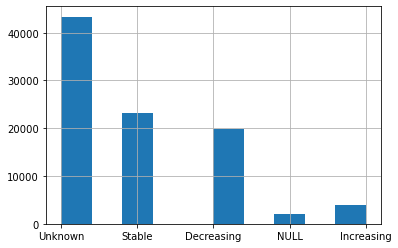

In [11]:
temp_iucn = iucn_data.copy()
temp_iucn.loc[temp_iucn['trend'].isna(), 'trend'] = 'NULL'
temp_iucn['trend'].hist()

In [12]:
print(
    'The dataset contains {} entries with available trend information (not Null or Unknown).'
    .format(
        len(iucn_data[(iucn_data['trend'].isna() == False)
                      & (iucn_data['trend'] != 'Unknown')])))

The dataset contains 47084 entries with available trend information (not Null or Unknown).


**NOTE: This is an issue and we have to think about a strategy how to deal with these missing/unknown values.**
Maybe we can check if these entries have some special characteristics.

# Country Characteristics Data

## Load and Merge

In [13]:
coun_list = []
country_sets = []
for file in PATHS_COUN:
    print(file)
    temp = pd.read_csv(file)
    coun_list.append(temp)
    country_sets.append(set(temp['Country']))

data/OECD/protected_areas_2020.csv
data/OECD/LAND_COVER_2018_DATA.csv
data/climate/climate_features.csv
data/OECD/greenhouse_gases_2020_pred.csv


In [14]:
intersect_countries = country_sets[0].intersection(
    country_sets[1], country_sets[2], country_sets[3])  ## add country_sets[3]
print(
    'The Country Characterisitcs Datasets contain {} intersecting countries, which are: {}'
    .format(len(intersect_countries), intersect_countries))

The Country Characterisitcs Datasets contain 42 intersecting countries, which are: {'Chile', 'Italy', 'Iceland', 'Slovenia', 'Argentina', 'United States', 'Germany', 'Indonesia', 'Finland', 'Latvia', 'Brazil', 'Denmark', 'Canada', 'Estonia', 'Mexico', 'Belgium', 'Poland', 'Slovak Republic', 'India', 'Russia', 'Korea', 'Greece', 'Australia', 'Sweden', 'Israel', 'France', 'Norway', 'Switzerland', 'Costa Rica', 'Japan', 'Czech Republic', 'Hungary', 'Luxembourg', 'Ireland', 'United Kingdom', 'Portugal', 'New Zealand', 'Colombia', 'Lithuania', 'Spain', 'Netherlands', 'Austria'}


--> Join Datasets on those countries.

In [15]:
coun_data = coun_list[0]
for coun in coun_list[1:]:
    coun_data = pd.merge(coun_data, coun, on='Country', how='inner')
coun_data.head()

,Country,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
0,Argentina,8.39,1.84,0.04,0.19,0.27,0.03,1.46,0.33,4.09,...,0.500525,0.072246,0,1.828861,4.710241,0.014370,1.002114,-1.000000,0.003744,0.000042
1,Australia,19.20,4.17,0.24,0.27,2.01,0.57,0.34,0.98,10.63,...,0.969423,0.214683,1,4.382540,16.642911,0.479420,0.804808,-1.000000,0.009443,0.009144
2,Austria,28.54,2.38,0.01,5.80,0.01,0.12,4.62,15.35,0.20,...,24.241043,1.498389,2,0.728541,7.549433,0.207606,0.398982,0.001868,0.003680,0.043241
3,Belgium,24.97,0.07,0.00,1.54,0.00,0.00,9.19,12.59,1.59,...,12.044550,1.167659,3,0.688260,8.787278,0.391962,0.500037,0.000057,0.011516,0.008337
4,Brazil,29.80,4.13,0.07,0.03,2.06,0.00,11.83,4.58,6.78,...,3.703937,0.929317,4,1.683181,2.566549,-1.000000,0.894033,-1.000000,-1.000000,-1.000000


## Analysis

### General Information

In [16]:
coun_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 41
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Country                      42 non-null     object 
 1   perc_area_protected_all_obj  42 non-null     float64
 2   perc_area_protected_obj_2    42 non-null     float64
 3   perc_area_protected_obj_3    42 non-null     float64
 4   perc_area_protected_obj_4    42 non-null     float64
 5   perc_area_protected_obj_1a   42 non-null     float64
 6   perc_area_protected_obj_1b   42 non-null     float64
 7   perc_area_protected_no_obj   42 non-null     float64
 8   perc_area_protected_obj_5    42 non-null     float64
 9   perc_area_protected_obj_6    42 non-null     float64
 10  Artificial surfaces          42 non-null     float64
 11  Bare area                    42 non-null     float64
 12  Cropland                     42 non-null     float64
 13  Grassland             

There are no missing values in the dataset.

In [17]:
coun_data.describe()

,perc_area_protected_all_obj,perc_area_protected_obj_2,perc_area_protected_obj_3,perc_area_protected_obj_4,perc_area_protected_obj_1a,perc_area_protected_obj_1b,perc_area_protected_no_obj,perc_area_protected_obj_5,perc_area_protected_obj_6,Artificial surfaces,...,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,SF6
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000
mean,22.282857,4.151667,0.362381,2.964762,0.445714,0.872619,6.900476,4.782381,1.533333,2.633913,...,10.864795,0.987359,22.095238,1.284412,7.478007,0.164214,0.586226,-0.666490,-0.154093,-0.036179
std,10.766357,5.984902,1.917474,3.469978,0.676599,1.827691,8.767212,5.999103,2.741055,2.734239,...,12.305045,0.448411,12.957359,1.194647,4.017188,0.297642,0.349903,0.477372,0.384327,0.219119
min,5.640000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-24.178355,0.072246,0.000000,0.236113,1.278950,-1.000000,0.092906,-1.000000,-1.000000,-1.000000
25%,14.287500,0.652500,0.000000,0.440000,0.000000,0.000000,0.472500,0.110000,0.000000,0.592425,...,3.832235,0.659961,11.250000,0.750174,4.848182,0.109285,0.345235,-1.000000,0.000021,0.002429
50%,20.370000,2.025000,0.020000,1.555000,0.070000,0.005000,3.375000,1.430000,0.085000,1.577312,...,9.547614,0.943211,22.500000,0.893499,6.846338,0.176891,0.481730,-1.000000,0.003712,0.007283
75%,27.892500,4.812500,0.070000,3.877500,0.545000,0.525000,11.290000,7.780000,1.552500,4.066111,...,17.897105,1.382112,32.750000,1.261372,9.078078,0.322812,0.849686,0.000009,0.012341,0.010464
max,53.530000,32.610000,12.470000,14.740000,2.180000,7.530000,40.300000,25.240000,10.630000,11.333710,...,43.855657,1.852533,44.000000,7.017958,16.642911,0.550778,1.554079,0.002234,0.216726,0.128989


In [18]:
coun_data['Country'].nunique()

42

# Full Data

## Merge both datasets

### Check Keys (countries)

In [19]:
iucn_countries = set(iucn_data['Country'].unique())
char_countries = set(coun_data['Country'].unique())
print('IUCN \ CHAR: {}'.format(iucn_countries.difference(char_countries)))
print('CHAR \ IUCN: {}'.format(char_countries.difference(iucn_countries)))

IUCN \ CHAR: {'Kazakhstan', 'Azerbaijan', 'Georgia', 'Tajikistan', 'Moldova', 'South Africa', 'Peru', 'Saudi Arabia', 'Turkmenistan', 'Cyprus', 'Uzbekistan', 'Kyrgyzstan', 'Malta', 'Armenia', 'Belarus', 'Bulgaria', 'Puerto Rico', 'Croatia', 'Northern Mariana Islands', 'Romania', 'New Caledonia', 'Greenland', 'Ukraine'}
CHAR \ IUCN: set()


In [28]:
oecd_list = [
    'AUSTRALIA', 'AUSTRIA', 'BELGIUM', 'CANADA', 'CHILE', 'COLOMBIA',
    'CZECH REPUBLIC', 'DENMARK', 'ESTONIA', 'FINLAND', 'FRANCE', 'GERMANY',
    'GREECE', 'HUNGARY', 'ICELAND', 'IRELAND', 'ISRAEL', 'ITALY', 'JAPAN',
    'KOREA', 'LATVIA', 'LITHUANIA', 'LUXEMBOURG', 'MEXICO', 'NETHERLANDS',
    'NEW ZEALAND', 'NORWAY', 'POLAND', 'PORTUGAL', 'SLOVAK REPUBLIC',
    'SLOVENIA', 'SPAIN', 'SWEDEN', 'SWITZERLAND', 'TURKEY', 'UNITED KINGDOM',
    'UNITED STATES'
]
oecd_list = [c.title() for c in oecd_list]
len(oecd_list)

37

In [32]:
set(oecd_list).difference(iucn_countries)

{'Turkey'}

In [34]:
set(oecd_list).difference(char_countries)

{'Turkey'}

In [30]:
iucn_diff_list = [c for c in iucn_countries.difference(char_countries)]
set(iucn_diff_list).intersection(set(oecd_list))

set()

In [ ]:
i

set()

### Rename Country Data to Match IUCN Data

In [20]:
coun_data.loc[coun_data['Country'] == 'New Zealand', 'Country'] = 'New_Zealand'
coun_data.loc[coun_data['Country'] == 'Slovak Republic', 'Country'] = 'Slovakia'
coun_data.loc[coun_data['Country'] == 'United Kingdom', 'Country'] = 'United_Kingdom'
coun_data.loc[coun_data['Country'] == 'United States', 'Country'] = 'United_States'
coun_data.loc[coun_data['Country'] == 'Czech Republic', 'Country'] = 'Czechia'
coun_data.loc[coun_data['Country'] == 'Korea', 'Country'] = 'Korea,_Republic_of'

### Merge 

In [21]:
full_data = iucn_data.merge(coun_data, on='Country', how='inner')
full_data['Country'].nunique()

36